# AIM: develop the pretext task with EEGNet & ShallowNet
Across subject pretext task

In [1]:
import numpy as np
import pandas as pd
import mne
import lightning.pytorch as pl
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchmetrics import F1Score, Accuracy
import random
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedGroupKFold
import itertools
from torch.utils.data import Dataset, DataLoader, Subset
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import warnings
%matplotlib inline

# prevent extensive logging
mne.set_log_level('WARNING')

## Pretext task

#### Functions & Classes

https://sthalles.github.io/simple-self-supervised-learning/

In [2]:
def get_participant_ids(eeg_dir, epoch_dir=False):
    """
    Function to get all participant ids from EEG data directory
    :param eeg_dir: directory where EEG data is stored
    :param epoch_dir: whether the data that we want to retrieve is from the epoch directory or from the raw EEG data directory
    :return: list of participant ids
    """
    participant_ids = []
    if epoch_dir == False:
        for subdir, dirs, files in os.walk(eeg_dir): # iterate through all files
            for file in files:
                if 'ses-1' in file and '.npy' in file and 'BAD' not in file: # filter first session, .npy files, and non-bad files
                    participant_id = file.split('_')[0] # extract participant id
                    if participant_id not in participant_ids:
                        participant_ids.append(participant_id)
    else:
        participant_ids = [file.split('.')[0] for file in os.listdir(eeg_dir) if '.pt' in file]
        
    return participant_ids


def train_pretext_model(pretext_task,
                        max_epochs,
                        data_train,
                        data_val,
                        batch_size,
                        learning_rate=0.001,
                        dropout=0.25,
                        weight_decay=0,
                        store_weights=(True, True),
                        num_extracted_features=100,
                        pretext_model='EEGNet'):
    """
    Function to train the pretext model
    :param pretext_task: title (string) describing the pretext task for saving the model weights
    :param max_epochs: maximum number of epochs to train the model
    :param data_train: training data
    :param data_val: validation data
    :param batch_size: batch size
    :param learning_rate: learning rate
    :param dropout: dropout rate
    :param weight_decay: weight decay
    :param store_weights: whether to store the weights of the overtrained model and the best checkpoint model
    :param num_extracted_features: number of features to extract
    :param pretext_model: model to use for the pretext task (EEGNet or ShallowNet)
    :return: trained model loaded with best checkpoint
    """
    # define the model class (Has to be defined here, otherwise using different amount of extracted features will result in errors)
    # create Conv2d with max norm constraint
    class Conv2dWithConstraint(nn.Conv2d):
        def __init__(self, *args, max_norm: int = 1, **kwargs):
            self.max_norm = max_norm
            super(Conv2dWithConstraint, self).__init__(*args, **kwargs)

        def forward(self, x: torch.Tensor) -> torch.Tensor:
            self.weight.data = torch.renorm(self.weight.data, p=2, dim=0, maxnorm=self.max_norm)
            return super(Conv2dWithConstraint, self).forward(x)
        
    class EEGNet(nn.Module):
        """
        Code taken and adjusted from pytorch implementation of EEGNet
        url: https://github.com/torcheeg/torcheeg/blob/v1.1.0/torcheeg/models/cnn/eegnet.py#L5
        """
        def __init__(self,
                    num_extracted_features: int = num_extracted_features, # number of features to extract  ## QUESTION
                    chunk_size: int = 1244, # number of data points in each EEG chunk
                    num_electrodes: int = 26, # number of EEG electrodes
                    F1: int = 8, # number of filters in first convolutional layer
                    F2: int = 16, # number of filters in second convolutional layer
                    D: int = 2, # depth multiplier
                    kernel_1: int = 64, # the filter size of block 1 (half of sfreq (125 Hz)) ## QUESTION 
                    kernel_2: int = 16, # the filter size of block 2 (one eight of sfreq (500 Hz)) ## QUESTION
                    dropout: float = 0.25): # dropout rate
            super(EEGNet, self).__init__()
            self.F1 = F1
            self.F2 = F2
            self.D = D
            self.chunk_size = chunk_size
            self.num_extracted_features = num_extracted_features
            self.num_electrodes = num_electrodes
            self.kernel_1 = kernel_1
            self.kernel_2 = kernel_2
            self.dropout = dropout

            self.block1 = nn.Sequential(
                nn.Conv2d(1, self.F1, (1, self.kernel_1), stride=1, padding=(0, self.kernel_1 // 2), bias=False),
                nn.BatchNorm2d(self.F1, momentum=0.01, affine=True, eps=1e-3),
                Conv2dWithConstraint(self.F1,
                                    self.F1 * self.D, (self.num_electrodes, 1),
                                    max_norm=1,
                                    stride=1,
                                    padding=(0, 0),
                                    groups=self.F1,
                                    bias=False), nn.BatchNorm2d(self.F1 * self.D, momentum=0.01, affine=True, eps=1e-3),
                nn.ELU(), nn.AvgPool2d((1, 4), stride=4), nn.Dropout(p=dropout))

            self.block2 = nn.Sequential(
                nn.Conv2d(self.F1 * self.D,
                        self.F1 * self.D, (1, self.kernel_2),
                        stride=1,
                        padding=(0, self.kernel_2 // 2),
                        bias=False,
                        groups=self.F1 * self.D),
                nn.Conv2d(self.F1 * self.D, self.F2, 1, padding=(0, 0), groups=1, bias=False, stride=1),
                nn.BatchNorm2d(self.F2, momentum=0.01, affine=True, eps=1e-3), nn.ELU(), nn.AvgPool2d((1, 8), stride=8),
                nn.Dropout(p=dropout))

            self.lin = nn.Linear(self.feature_dim(), num_extracted_features, bias=False)


        def feature_dim(self):
            # function to calculate the number of features after the convolutional blocks
            with torch.no_grad():
                mock_eeg = torch.zeros(1, 1, self.num_electrodes, self.chunk_size)

                mock_eeg = self.block1(mock_eeg)
                mock_eeg = self.block2(mock_eeg)

            return self.F2 * mock_eeg.shape[3]

        def forward(self, x: torch.Tensor) -> torch.Tensor:
            x = self.block1(x)
            x = self.block2(x)
            x = x.flatten(start_dim=1)
            x = self.lin(x)
            return x
        
    class ShallowNet(nn.Module):
        """
        Pytorch implementation of the ShallowNet Encoder.
        Code taken and adjusted from:
        https://github.com/MedMaxLab/selfEEG/blob/024402ba4bde95051d86ab2524cc71105bfd5c25/selfeeg/models/zoo.py#L693
        """

        def __init__(self,
                    samples=1244,
                    chans=26, # number of EEG channels
                    F=40, # number of output filters in the temporal convolution layer
                    K1=25, # length of the temporal convolutional layer
                    pool=75, # temporal pooling kernel size
                    dropout=0.2, # dropout probability
                    num_extracted_features=num_extracted_features # number of features to extract
                    ):

            super(ShallowNet, self).__init__()
            self.conv1 = nn.Conv2d(1, F, (1, K1), stride=(1, 1))
            self.conv2 = nn.Conv2d(F, F, (chans, 1), stride=(1, 1))
            self.batch1 = nn.BatchNorm2d(F)
            self.pool2 = nn.AvgPool2d((1, pool), stride=(1, 15))
            self.flatten2 = nn.Flatten()
            self.drop1 = nn.Dropout(dropout)
            self.lin = nn.Linear(
                F * ((samples - K1 + 1 - pool) // 15 + 1), num_extracted_features
            )

        def forward(self, x):
            x = self.conv1(x)
            x = self.conv2(x)
            x = self.batch1(x)
            x = torch.square(x)
            x = self.pool2(x)
            x = torch.log(torch.clamp(x, 1e-7, 10000))
            x = self.flatten2(x)
            x = self.drop1(x)
            x = self.lin(x)

            return x
        
    if pretext_model == 'EEGNet':
        class PretextModel(pl.LightningModule):
            def __init__(self, num_extracted_features=num_extracted_features, dropout=0.25, weight_decay=0.00, learning_rate=0.001):
                super(PretextModel, self).__init__()
                self.weight_decay = weight_decay
                self.learning_rate = learning_rate
                # feature extractors
                self.EEGNet = EEGNet(num_extracted_features=num_extracted_features, dropout=dropout)
                
                # mlp projection head
                self.linear = nn.Linear(num_extracted_features, num_extracted_features)

                # add metrics
                self.train_f1 = F1Score(task='multiclass', num_classes=2, average='macro')
                self.val_f1 = F1Score(task='multiclass', num_classes=2, average='macro')

            def forward(self, x1: torch.Tensor, x2) -> torch.Tensor:
                x1 = self.EEGNet(x1) # forward pass through EEGNet for first sample
                x2 = self.EEGNet(x2) # forward pass through EEGNet for second sample
                ## QUESTION: SHOULD I ADD ANOTHER LINEAR LAYER HERE FIRST?
                x1 = F.relu(x1)
                x2 = F.relu(x2)
                z1 = self.linear(x1) # forward pass through linear layer
                z2 = self.linear(x2)
                
                return z1, z2
            
            def training_step(self, train_batch, batch_idx):
                x = train_batch[0]
                y = train_batch[1]
                y = y.float()
                x1 = x[:, 0, :, :].unsqueeze(1).float()
                x2 = x[:, 1, :, :].unsqueeze(1).float()
                z1, z2 = self.forward(x1, x2)
                loss = self.contrastive_loss(z1, z2, y)
                self.log('train_loss', loss, on_epoch=True, prog_bar=True)
                # self.log('train_f1', self.train_f1(y_hat, y), prog_bar=True, on_epoch=True)
                return loss
            
            def validation_step(self, val_batch, batch_idx):
                x = val_batch[0]
                # print(x.shape)
                y = val_batch[1]
                y = y.float()
                # print(y)
                x1 = x[:, 0, :, :].unsqueeze(1).float()
                x2 = x[:, 1, :, :].unsqueeze(1).float()
                z1, z2 = self.forward(x1, x2)
                # print(f'{z1.shape=}')
                # print(f'{z2.shape=}')
                # print(f'{y.shape=}')
                loss = self.contrastive_loss(z1, z2, y)
                self.log('val_loss', loss, prog_bar=True, on_epoch=True)
                # self.log('val_f1', self.val_f1(y_hat, y), prog_bar=True, on_epoch=True)
                return loss
            
            def test_step(self, test_batch, batch_idx):
                x = test_batch[0]
                y = test_batch[1]
                y = y.float()
                x1 = x[:, 0, :, :].unsqueeze(1).float()
                x2 = x[:, 1, :, :].unsqueeze(1).float()
                z1, z2 = self.forward(x1, x2)
                loss = self.contrastive_loss(z1, z2, y)
                self.log('test_loss', loss, prog_bar=True)
                # self.log('test_f1', self.val_f1(y_hat, y), prog_bar=True)
                return loss
            
            def predict_step(self, batch): ##TODO: Change
                x = batch[0]
                x1 = x[:, 0, :, :].unsqueeze(1).float()
                x2 = x[:, 1, :, :].unsqueeze(1).float()
                logits = self.forward(x1, x2)
                logits = logits.view(-1)
                y_hat = F.sigmoid(logits)
                y_hat = torch.where(y_hat > 0.5, 1, 0)
                return y_hat
            
            def configure_optimizers(self):
                optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, betas=(0.9, 0.999), weight_decay=self.weight_decay) # default hyperparameters (used in EEGNet paper)
                return optimizer
            
            def contrastive_loss(self, z1, z2, y, temperature=0.1):
                # application of NT-Xent loss https://theaisummer.com/simclr/
                batch_size = z1.shape[0]
                # first L2 normalization ## TODO: Not sure if necessary, considering already regularization with cosine_similarity
                # z1 = F.normalize(z1, p=2, dim=1)
                # z2 = F.normalize(z2, p=2, dim=1)

                representations = torch.cat([z1, z2], dim=0) # [2 X batch_size, n_features]
                # print(f'{representations.shape=}')
                # print(f'{representations.unsqueeze(1).shape=}')
                # print(f'{representations.unsqueeze(0).shape=}')
                similarity_matrix = F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2) # [batch_size X views, batch_size X views]
                # print(f'{similarity_matrix.shape=}')

                # index positive and negative pairs
                sim_ij = torch.diag(similarity_matrix, batch_size)
                sim_ji = torch.diag(similarity_matrix, -batch_size)
                # print(f'{sim_ij.shape=}')
                # print(f'{sim_ij=}')
                # print(f'{sim_ji.shape=}')
                # print(f'{sim_ji=}')
                positives = torch.cat([sim_ij, sim_ji], dim=0)
                # print(f'{positives.shape=}')
                mask = (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float()
                # print(f'{mask.shape=}')
                # print(f'{mask=}')
                # move mask to same device as similarity_matrix
                mask = mask.to(similarity_matrix.device)

                # exclude positive pairs from similarity matrix
                negatives = similarity_matrix * mask

                nominator = torch.exp(positives / temperature)
                denominator = torch.sum(torch.exp(negatives / temperature), dim=1)
                all_losses = -torch.log(nominator / denominator)
                loss = torch.sum(all_losses) / (2 * batch_size)
                return loss

            def nt_xent_loss(x, temperature):
                # https://towardsdatascience.com/nt-xent-normalized-temperature-scaled-cross-entropy-loss-explained-and-implemented-in-pytorch-cc081f69848
                assert len(x.size()) == 2

                # Cosine similarity
                xcs = F.cosine_similarity(x[None,:,:], x[:,None,:], dim=-1)
                xcs[torch.eye(x.size(0)).bool()] = float("-inf")

                # Ground truth labels
                target = torch.arange(8)
                target[0::2] += 1
                target[1::2] -= 1

                # Standard cross-entropy loss
                return F.cross_entropy(xcs / temperature, target, reduction="mean")

            def contrastive_loss_old(self, z1, z2, y, temperature=0.1):
                # application of NT-Xent loss
                # calculate contrastive loss in 2*(batch_size-1) steps
                total_loss = 0
                batch_size = len(torch.where(y == 1)[0])
                cosine_similarity = torch.cosine_similarity(z1, z2, dim=1)
                # print(cosine_similarity.shape)

                positive_pair_indices = torch.where(y == 1)[0]
                # print(positive_pair_indices)
                # print(y)

                for i in positive_pair_indices:
                    positive_pair_loss = torch.exp(cosine_similarity[i] / temperature)
                    negative_pairs_loss = 0
                    # print(f'{i=}')
                    # print('==========================================')
                    # print(f'{batch_size=}')
                    # print(f'{batch_size-1}')
                    for j in range(0, (batch_size-1)): # get negative pairs related to positive pair
                        # print(f'{j=}')
                        # print(f'{i+j+1=}')
                        # print('-------------')
                        negative_pairs_loss += torch.exp(cosine_similarity[i+j+1] / temperature)
                    loss = -torch.log(positive_pair_loss / negative_pairs_loss)
                    total_loss += loss
                
                average_loss = total_loss / batch_size
                return average_loss

    elif pretext_model == 'ShallowNet':
        class PretextModel(pl.LightningModule):
            def __init__(self, num_extracted_features=num_extracted_features, dropout=0.25, weight_decay=0.00, learning_rate=0.001):
                super(PretextModel, self).__init__()
                self.weight_decay = weight_decay
                self.learning_rate = learning_rate
                # feature extractors
                self.ShallowNet = ShallowNet(num_extracted_features=num_extracted_features, dropout=dropout)
                
                # linear discriminate layer
                self.linear = nn.Linear(num_extracted_features, 1)

                # add metrics
                self.train_f1 = F1Score(task='multiclass', num_classes=2, average='macro')
                self.val_f1 = F1Score(task='multiclass', num_classes=2, average='macro')

            def forward(self, x1: torch.Tensor, x2) -> torch.Tensor:
                x1 = self.ShallowNet(x1) # forward pass through ShallowNet for first sample
                x2 = self.ShallowNet(x2) # forward pass through ShallowNet for second sample
                z = torch.abs(x1 - x2) # calculate the absolute difference between the two feature vectors (contrastive module)
                x = self.linear(z) # forward pass through linear layer
                return x
            
            def training_step(self, train_batch, batch_idx):
                x = train_batch[0]
                y = train_batch[1]
                y = y.float()
                x1 = x[:, 0, :, :].unsqueeze(1).float()
                x2 = x[:, 1, :, :].unsqueeze(1).float()
                logits = self.forward(x1, x2)
                logits = logits.view(-1)
                loss = F.binary_cross_entropy_with_logits(logits, y)
                y_hat = F.sigmoid(logits)
                y_hat = torch.where(y_hat > 0.5, 1, 0)
                self.log('train_loss', loss, on_epoch=True, prog_bar=True)
                self.log('train_f1', self.train_f1(y_hat, y), prog_bar=True, on_epoch=True)
                return loss
            
            def validation_step(self, val_batch, batch_idx):
                x = val_batch[0]
                y = val_batch[1]
                y = y.float()
                x1 = x[:, 0, :, :].unsqueeze(1).float()
                x2 = x[:, 1, :, :].unsqueeze(1).float()
                logits = self.forward(x1, x2)
                logits = logits.view(-1)
                loss = F.binary_cross_entropy_with_logits(logits, y)
                y_hat = F.sigmoid(logits)
                y_hat = torch.where(y_hat > 0.5, 1, 0)
                self.log('val_loss', loss, prog_bar=True, on_epoch=True)
                self.log('val_f1', self.val_f1(y_hat, y), prog_bar=True, on_epoch=True)
                return loss
            
            def test_step(self, test_batch, batch_idx):
                x = test_batch[0]
                y = test_batch[1]
                y = y.float()
                x1 = x[:, 0, :, :].unsqueeze(1).float()
                x2 = x[:, 1, :, :].unsqueeze(1).float()
                logits = self.forward(x1, x2)
                logits = logits.view(-1)
                loss = F.binary_cross_entropy_with_logits(logits, y)
                y_hat = F.sigmoid(logits)
                y_hat = torch.where(y_hat > 0.5, 1, 0)
                self.log('test_loss', loss, prog_bar=True)
                self.log('test_f1', self.val_f1(y_hat, y), prog_bar=True)
                return loss
            
            def predict_step(self, batch):
                x = batch[0]
                x1 = x[:, 0, :, :].unsqueeze(1).float()
                x2 = x[:, 1, :, :].unsqueeze(1).float()
                logits = self.forward(x1, x2)
                logits = logits.view(-1)
                y_hat = F.sigmoid(logits)
                y_hat = torch.where(y_hat > 0.5, 1, 0)
                return y_hat
            
            def configure_optimizers(self):
                optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, betas=(0.9, 0.999), weight_decay=self.weight_decay) # default hyperparameters (used in EEGNet paper)
                return optimizer
            


    # remove particular warnings
    warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")
    warnings.filterwarnings("ignore", ".*Trying to infer the `batch_size` from an ambiguous collection*")

    logger = CSVLogger("logs", name="contrastive_loss_pretext_task") # log results to csv file
    torch.set_float32_matmul_precision('high') # for use of tensor cores
    # create pretext model
    model = PretextModel(learning_rate=learning_rate, dropout=dropout, weight_decay=weight_decay, num_extracted_features=num_extracted_features)
    
    # create data loaders
    train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(data_val, batch_size=batch_size, shuffle=False)
    
    checkpoint_callback = ModelCheckpoint(monitor='val_loss',
                                    mode='max',
                                    save_top_k=3,
                                    filename='{epoch}-{train_loss:.2f}-{train_f1:.2f}-{val_loss:.2f}-{val_f1:.2f}',
                                    )

    trainer = Trainer(
        precision='16-mixed',
        accelerator='gpu',
        devices=1,
        max_epochs=max_epochs,
        callbacks=checkpoint_callback,
        enable_progress_bar=True,
        enable_model_summary=True,
        enable_checkpointing=True,
        logger=logger,
        log_every_n_steps=5,
    )

    trainer.fit(model, train_loader, val_loader)

    if store_weights[0]:
        torch.save(model.state_dict(), f'D:/Documents/Master_Data_Science/Thesis/thesis_code/DataScience_Thesis/data/pretext_model_weights/overtrained_{pretext_task}_weights.pt')
    
    # load best model checkpoint
    print(f"Best model checkpoint path: {checkpoint_callback.best_model_path}")
    best_model = PretextModel.load_from_checkpoint(checkpoint_callback.best_model_path, strict=False)
    
    if store_weights[1]:
        torch.save(best_model.state_dict(), f'D:/Documents/Master_Data_Science/Thesis/thesis_code/DataScience_Thesis/data/pretext_model_weights/{pretext_task}_weights.pt')

    return best_model

def plot_training_curves(metrics_path):
    """
    Function to plot training curves from csv log file
    :param metrics_path: path to the csv file containing the model diagnostics
    :return:
    """
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))

    metrics = pd.read_csv(metrics_path)

    # Check if 'train_f1_epoch' and 'val_f1' columns exist
    if 'train_f1_epoch' in metrics.columns and 'val_f1' in metrics.columns:
        train_f1_epoch = metrics['train_f1_epoch'].dropna()
        val_f1 = metrics['val_f1'].dropna()
        axs[0].plot(train_f1_epoch, label='Train F1 Score')
        axs[0].plot(val_f1, label='Validation F1 Score')
        axs[0].set_title('F1 Score')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('F1 Score')
        axs[0].legend()
    else:
        print("F1 score columns not found in the metrics file.")

    # Check if 'train_loss' and 'val_loss' columns exist
    if 'train_loss_epoch' in metrics.columns and 'val_loss' in metrics.columns:
        train_loss = metrics['train_loss_epoch'].dropna()
        val_loss = metrics['val_loss'].dropna()
        axs[1].plot(train_loss, label='Train Loss')
        axs[1].plot(val_loss, label='Validation Loss')
        axs[1].set_title('Loss')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Loss')
        axs[1].legend()
    else:
        print("Loss columns not found in the metrics file.")

    plt.tight_layout()
    plt.show()

    return

def evaluate_pretext_model(model, data_test, test_labels, batch_size=None):
    """
    Function to evaluate the pretext model
    :param model: trained model
    :param data_test: test data
    :param test_labels: test labels
    :param batch_size: batch size
    :return: test results
    """
    if batch_size is None:
        batch_size = len(data_test)
        
    # obtain predictions on test set and plot confusion matrix
    test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=False,
                                drop_last=True, collate_fn=contrastive_collate_fn)

    # model = PretextModel.load_from_checkpoint(r'D:\Documents\Master_Data_Science\Thesis\thesis_code\DataScience_Thesis\logs\pretext_task\version_15\checkpoints\epoch=45-train_loss=54.10-train_f1=0.67-val_loss=106.12-val_f1=0.72.ckpt')

    trainer = Trainer(accelerator='gpu', devices=1, enable_progress_bar=False, enable_model_summary=False, logger=False, enable_checkpointing=False)
    trainer.test(model, test_loader)

    # compute confusion matrix and classification report with sklearn of best model checkpoint
    from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
    y_pred = trainer.predict(model, test_loader)
    y_pred = np.concatenate(y_pred).flatten()
    y = test_labels

    class_labels = ['Within-subject', 'Across-subject']
    print('classification report:\n', classification_report(y, y_pred, target_names=class_labels))
    print('F1-score:\n', f1_score(y, y_pred, average="macro"))
    print('Accuracy:\n', (y == y_pred).sum() / len(y))
    cm = confusion_matrix(y, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels).plot(cmap = 'Blues', values_format = 'd', colorbar=False)
    plt.grid(False)

    return

In [3]:
class Contrastive_Loss_Dataset(Dataset):
    def __init__(self, participant_ids, data_path, device='cpu', n_samples=1):
        """
        Dataset for the pretext task with contrastive loss and neurologist recommended augmentations. 
        For each participant samples n epochs on which two random augmentations are applied.
        The samples are then used to learn to predict if two augmentations were derived from the same original epoch,
        or two different epochs.
        :param participant_ids: List of participant IDs
        :param data_path: Path to the directory containing the preprocessed EEG data
        :param device: Device to store the data ('cpu' or 'cuda')
        :param n_samples: Number of epochs to sample from each participant
        :param neg_samples: Number of negative samples to create for each positive sample
        """
        self.participant_ids = participant_ids
        self.data_path = data_path
        self.device = device
        self.n_samples = n_samples
        self.sampled_epochs_indices_id = []
        self.data_cache = {}
        self.labels = []
        self._load_data()

        self.available_augmentations = {
            "amplitude_scale": [0.5, 2], 
            "time_shift": [-50, 50], 
            "DC_shift": [-10, 10], 
            "zero-masking": [0, 150], 
            "additive_Gaussian_noise": [0, 0.2], 
            "band-stop_filter": [2.8, 61], # max is nyquist frequency
        }

        self.NUM_AUGMENTATIONS = 1 # number of augmentations to apply to each epoch
        self.TEMPORAL_LEN = 1244 # length of the EEG signal
        self.SFREQ = 125 # sampling frequency of the EEG signal ## QUESTION: SHOULD I USE ORIGINAL SFREQ OR DOWNSAMPLED 125 HZ

    def _load_data(self):
        epoch_data = {}
        for participant_id in self.participant_ids:
            # Load the data for the participant
            data = torch.load(os.path.join(self.data_path, f"{participant_id}.pt"))
            # Move data to the specified device
            data = torch.tensor(data)
            data = data.to(self.device)
            self.data_cache[participant_id] = data
        # sample n epochs from each participant
        self.sample_epochs(self.data_cache, n=self.n_samples)
    
    def sample_epochs(self, data_cache, n):
        for participant in data_cache.keys():
            data = data_cache[participant]
            n_epochs = data.shape[0]
            sampled_epochs_indices = random.sample(range(n_epochs), n)
            for sampled_epoch_idx in sampled_epochs_indices:
                self.sampled_epochs_indices_id.append((participant, sampled_epoch_idx))
        return
    
    def get_augmentation_set(self):
        # taken and adjusted from https://github.com/zacharycbrown/ssl_baselines_for_biosignal_feature_extraction/blob/main/data_loaders.py#L535
        augmentation_set = []
        selected_augmentations = random.sample(list(self.available_augmentations.keys()), self.NUM_AUGMENTATIONS)
        assert len(selected_augmentations) == self.NUM_AUGMENTATIONS

        for aug in selected_augmentations:
            if aug in ['amplitude_scale', 'DC_shift', 'additive_Gaussian_noise', 'band-stop_filter']: # augmentation that requires float val
                aug_param = random.uniform(self.available_augmentations[aug][0], self.available_augmentations[aug][1])
            elif aug in ['time_shift', 'zero-masking']: # augmentation that requires int val
                aug_param = random.randint(self.available_augmentations[aug][0], self.available_augmentations[aug][1])
                if aug == 'zero-masking':
                    aug_param = [aug_param, random.randint(0, self.TEMPORAL_LEN-1)]
            else:
                raise NotImplementedError(f"Augmentation {aug} not implemented")
            
            if aug == 'band-stop_filter': # somehow getting a value higher than given range
                if aug_param > 61:
                    print(f'band_stop_filter: {aug_param=}')
            augmentation_set.append((aug, aug_param))
        return augmentation_set
            
    def apply_augmentation(self, sampled_epoch, augmentation):
        # apply augmentation to the sampled epoch with shape [n_channels, n_samples] ## QUESTION: IN CASE OF MULTIPLE AUGMENTATIONS WHICH FIRST?
        for aug in augmentation: # apply each augmentation
            if aug[0] == 'amplitude_scale':
                sampled_epoch = sampled_epoch * aug[1]

            elif aug[0] == 'time_shift':
                sampled_epoch = torch.roll(sampled_epoch, aug[1], dims=1)

            elif aug[0] == 'DC_shift':
                sampled_epoch = sampled_epoch + aug[1]

            elif aug[0] == 'zero-masking':
                sampled_epoch[:, aug[1][0]:aug[1][1]] = 0

            elif aug[0] == 'additive_Gaussian_noise':
                sampled_epoch = sampled_epoch + torch.randn_like(sampled_epoch) * aug[1]

            elif aug[0] == 'band-stop_filter':
                # Convert to NumPy array for notch_filter
                sampled_epoch_np = sampled_epoch.cpu().numpy()
                filtered_epoch_np = mne.filter.notch_filter(sampled_epoch_np, Fs=self.SFREQ, freqs=aug[1])
                # Convert back to PyTorch tensor
                sampled_epoch = torch.tensor(filtered_epoch_np, device=self.device)

            else:
                raise NotImplementedError(f"Augmentation {aug[0]} not implemented")
        augmented_epoch = sampled_epoch
        return augmented_epoch # shape [n_channels, n_samples]

    def __len__(self):
        return len(self.sampled_epochs_indices_id)

    def __getitem__(self, idx):
        participant_id, i = self.sampled_epochs_indices_id[idx]
        data = self.data_cache[participant_id]
        sampled_epoch = data[i]
        # create positive pair
        augmentation_set_1 = self.get_augmentation_set()
        augmentation_set_2 = self.get_augmentation_set()
        augmented_epoch_1 = self.apply_augmentation(sampled_epoch, augmentation_set_1)
        augmented_epoch_2 = self.apply_augmentation(sampled_epoch, augmentation_set_2)
        augmented_epochs = torch.stack([augmented_epoch_1, augmented_epoch_2]) # shape [2, n_channels, n_samples]
        # Convert to PyTorch tensor if it's a NumPy array
        if isinstance(augmented_epochs, np.ndarray):
            augmented_epochs = torch.tensor(augmented_epochs)
        # Transfer data to GPU in batches
        augmented_epochs = augmented_epochs.to(self.device)
        # Create a positive pair (label 1)
        positive_pair = (augmented_epochs, torch.tensor(1.0, device=self.device))

        return positive_pair

#### Data loading & splitting

In [4]:
data_path = r"E:\TDBRAIN\thesis_epoched_data\EC"
participant_ids = get_participant_ids(data_path, epoch_dir=True)
# sample_ids = random.sample(participant_ids, 100)                                          
dataset = Contrastive_Loss_Dataset(participant_ids, data_path, device='cuda', n_samples=1)
print(len(dataset))

# Create a DataLoader to check input
dataloader = DataLoader(dataset, batch_size=5, shuffle=True)

# Iterate through the DataLoader
for batch in dataloader:
    pairs, labels = batch
    
    # Unpack pairs and labels
    print(f'{pairs.shape=}')
    print(f'{labels.shape=}')
    print(f'Unique labels: {torch.unique(labels, return_counts=True)}')
    print(f'{labels=}')
    break

1244
pairs.shape=torch.Size([5, 2, 26, 1244])
labels.shape=torch.Size([5])
Unique labels: (tensor([1.], device='cuda:0'), tensor([5], device='cuda:0'))
labels=tensor([1., 1., 1., 1., 1.], device='cuda:0')


In [5]:
# First obtain indices of the train/val/test sets to limit code rerun time
# obtain indices of the replication set in dataset as test set (participants starting with 'sub-19')
replication_indices = [idx for idx, sample in enumerate(dataset.sampled_epochs_indices_id) if sample[0].startswith('sub-19')]
# obtain the rest of the indices as train and validation set
trainval_indices = [idx for idx in range(len(dataset)) if idx not in replication_indices]

groups = [dataset.sampled_epochs_indices_id[idx][0] for idx in trainval_indices]

# stratified group kfold split
from sklearn.model_selection import GroupKFold
sgkf = GroupKFold(n_splits=5)

# Split the train and validation set into train and validation set
for train_idx, val_idx in sgkf.split(trainval_indices, groups=groups):
    train_indices = [trainval_indices[i] for i in train_idx]
    val_indices = [trainval_indices[i] for i in val_idx]
    break  # We only need the first split

# Save indices to disk
np.save('data_train_indices.npy', train_indices)
np.save('data_val_indices.npy', val_indices)
np.save('data_test_indices.npy', replication_indices)

In [6]:
# obtain actual train, val, test splits
# code from github copilot

# Load indices from disk
data_train_indices = np.load('data_train_indices.npy')
data_val_indices = np.load('data_val_indices.npy')
data_test_indices = np.load('data_test_indices.npy')

# Create subsets using the indices
data_train = Subset(dataset, data_train_indices)
data_val = Subset(dataset, data_val_indices)
data_test = Subset(dataset, data_test_indices)

# Print dataset sizes and label distributions
# train_labels = [dataset.labels[i] for i in data_train_indices]
# val_labels = [dataset.labels[i] for i in data_val_indices]
# test_labels = [dataset.labels[i] for i in data_test_indices]

print(f"Train: {len(data_train)}, Val: {len(data_val)}, Test: {len(data_test)}")
# print(f"Train: {np.unique(train_labels, return_counts=True)}")
# print(f"Val: {np.unique(val_labels, return_counts=True)}")
# print(f"Test: {np.unique(test_labels, return_counts=True)}")

Train: 910, Val: 228, Test: 106


## Training default pretext model 

In [7]:
# train pretext model with default parameters
model = train_pretext_model(
    pretext_task='contrastive_loss_default_pretext_model',
    max_epochs=100,
    data_train=data_train,
    data_val=data_val,
    batch_size=500,
    learning_rate=0.001,
    dropout=0.25,
    weight_decay=0,
    store_weights=(True, True)
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | EEGNet   | EEGNet            | 63.9 K
1 | linear   | Linear            | 10.1 K
2 | train_f1 | MulticlassF1Score | 0     
3 | val_f1   | MulticlassF1Score | 0     
-----------------------------------------------
74.0 K    Trainable params
0         Non-trainable params
74.0 K    Total params
0.296     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Best model checkpoint path: logs\contrastive_loss_pretext_task\version_1\checkpoints\epoch=0-train_loss=5.63-train_f1=0.00-val_loss=4.70-val_f1=0.00.ckpt


F1 score columns not found in the metrics file.


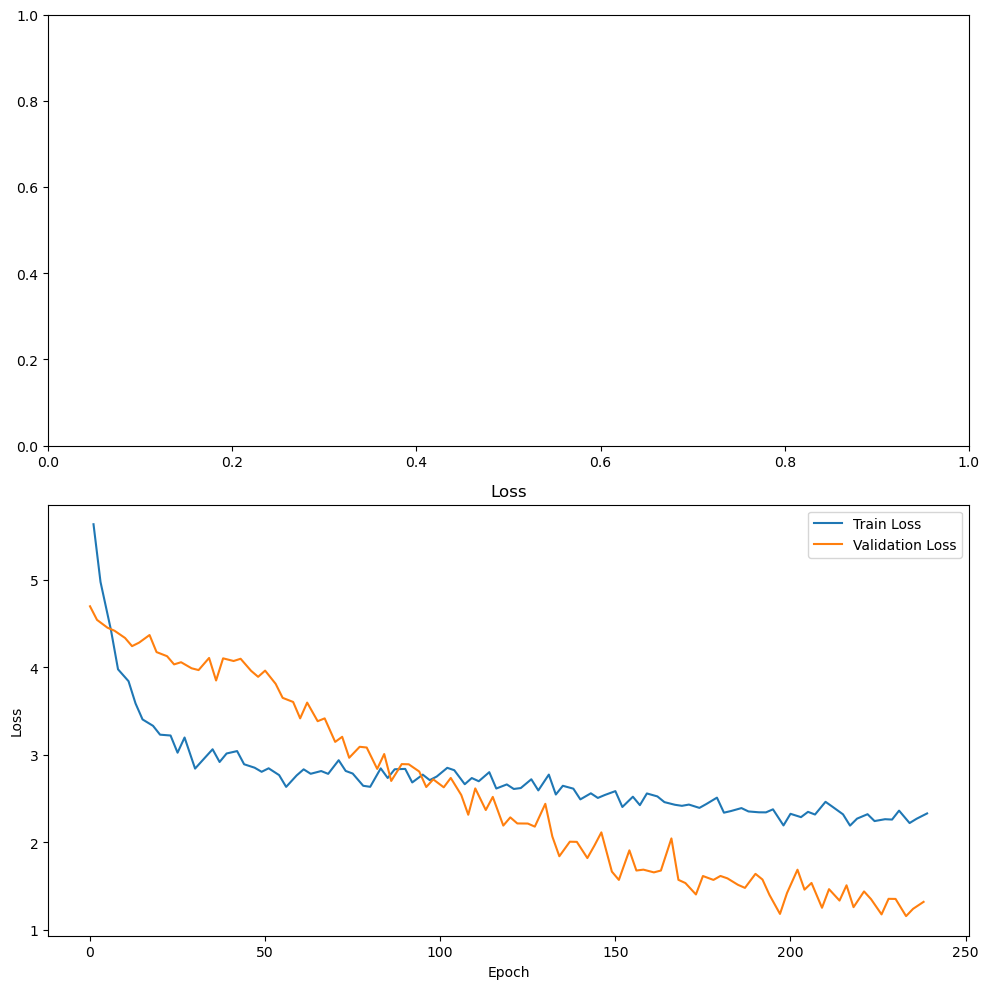

In [9]:
# plot training curves
plot_training_curves(r'D:\Documents\Master_Data_Science\Thesis\thesis_code\DataScience_Thesis\logs\contrastive_loss_pretext_task\version_1\metrics.csv')

## Training default pretext model with ShallowNet

In [7]:
# train pretext model with default parameters
model = train_pretext_model(
    pretext_task='acrosssub_shallownet_default_pretext_model',
    max_epochs=3,
    data_train=data_train,
    data_val=data_val,
    batch_size=500,
    learning_rate=0.001,
    dropout=0.25,
    weight_decay=0,
    store_weights=(True, True),
    pretext_model='ShallowNet'
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params
-------------------------------------------------
0 | ShallowNet | ShallowNet        | 350 K 
1 | linear     | Linear            | 101   
2 | train_f1   | MulticlassF1Score | 0     
3 | val_f1     | MulticlassF1Score | 0     
-------------------------------------------------
350 K     Trainable params
0         Non-trainable params
350 K     Total params
1.404     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


Best model checkpoint path: logs\across_sub_pretext_task\version_11\checkpoints\epoch=2-train_loss=0.14-train_f1=0.95-val_loss=0.16-val_f1=0.94.ckpt


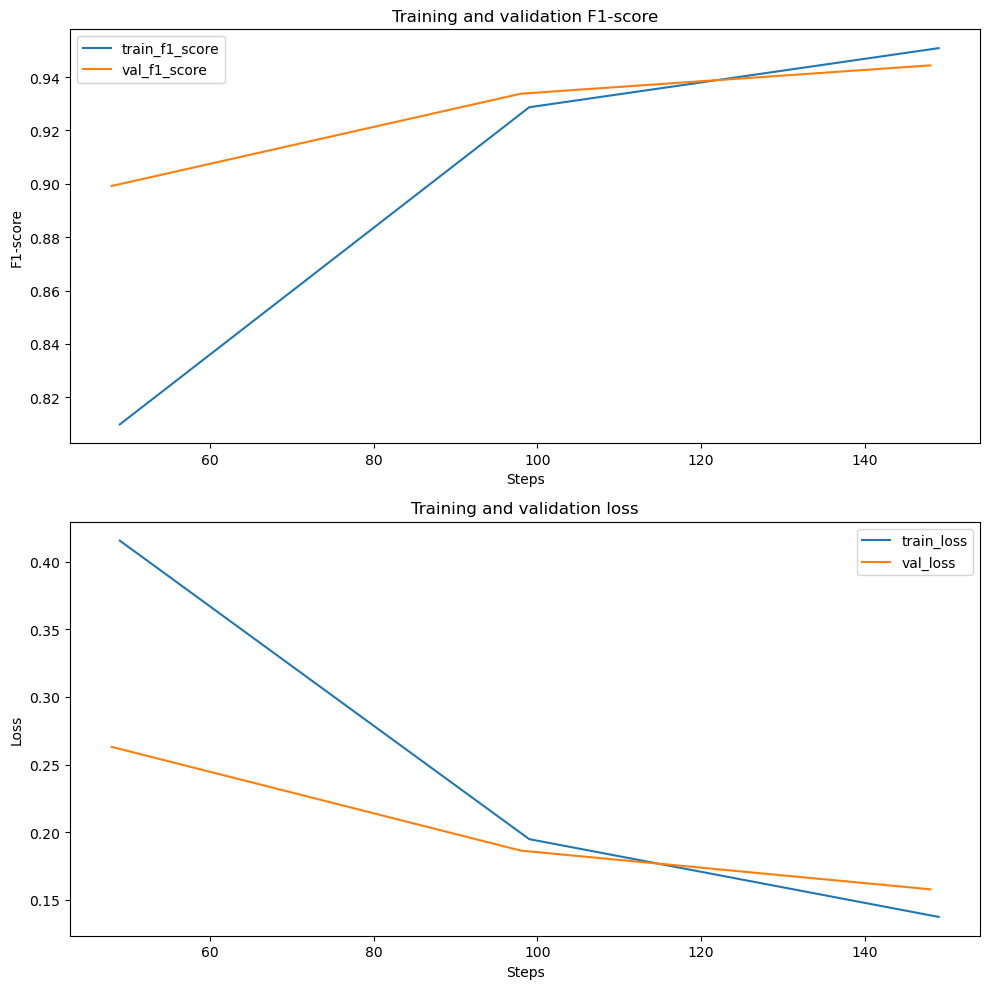

In [8]:
# plot training curves
plot_training_curves(r'D:\Documents\Master_Data_Science\Thesis\thesis_code\DataScience_Thesis\logs\across_sub_pretext_task\version_11\metrics.csv')

## Pretext model with 0.5 dropout 0.01 weight decay

In [9]:
model = train_pretext_model(
    pretext_task='acrosssub_0.5dropout_0.01wd_pretext_model',
    max_epochs=50,
    data_train=data_train,
    data_val=data_val,
    batch_size=1000,
    learning_rate=1e-5,
    dropout=0.5,
    weight_decay=0.01,
    store_weights=(True, True)
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | EEGNet   | EEGNet            | 63.9 K
1 | linear   | Linear            | 101   
2 | train_f1 | MulticlassF1Score | 0     
3 | val_f1   | MulticlassF1Score | 0     
-----------------------------------------------
64.0 K    Trainable params
0         Non-trainable params
64.0 K    Total params
0.256     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Best model checkpoint path: logs\across_sub_pretext_task\version_1\checkpoints\epoch=49-train_loss=0.48-train_f1=0.79-val_loss=0.50-val_f1=0.78.ckpt


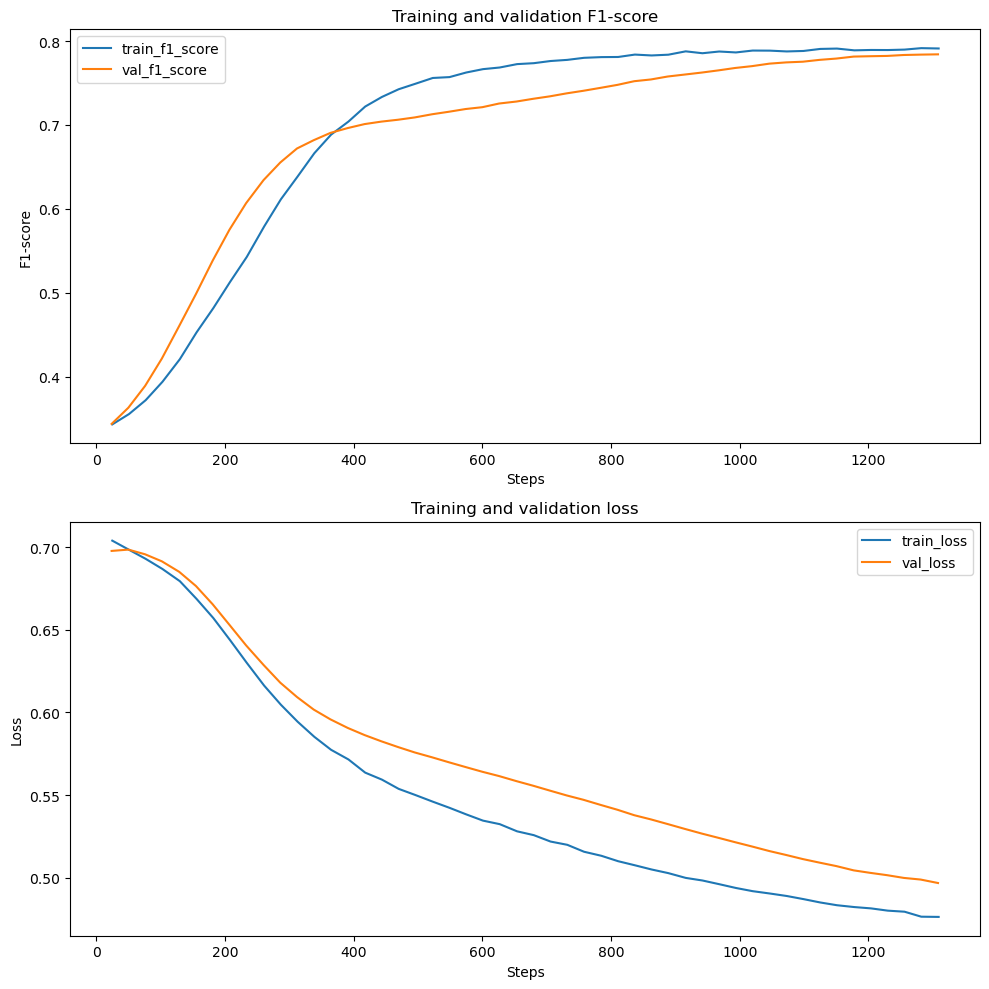

In [10]:
# plot training curves
plot_training_curves(r'D:\Documents\Master_Data_Science\Thesis\thesis_code\DataScience_Thesis\logs\across_sub_pretext_task\version_1\metrics.csv')

## ShallowNet 0.5 dropout and 0.01 weight decay pretext model

In [7]:
# train pretext model with default parameters
model = train_pretext_model(
    pretext_task='acrosssub_0.5do_0.01wd_shallownet_default_pretext_model',
    max_epochs=10,
    data_train=data_train,
    data_val=data_val,
    batch_size=500,
    learning_rate=0.001,
    dropout=0.5,
    weight_decay=0.01,
    store_weights=(True, True),
    pretext_model='ShallowNet'
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params
-------------------------------------------------
0 | ShallowNet | ShallowNet        | 350 K 
1 | linear     | Linear            | 101   
2 | train_f1   | MulticlassF1Score | 0     
3 | val_f1     | MulticlassF1Score | 0     
-------------------------------------------------
350 K     Trainable params
0         Non-trainable params
350 K     Total params
1.404     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

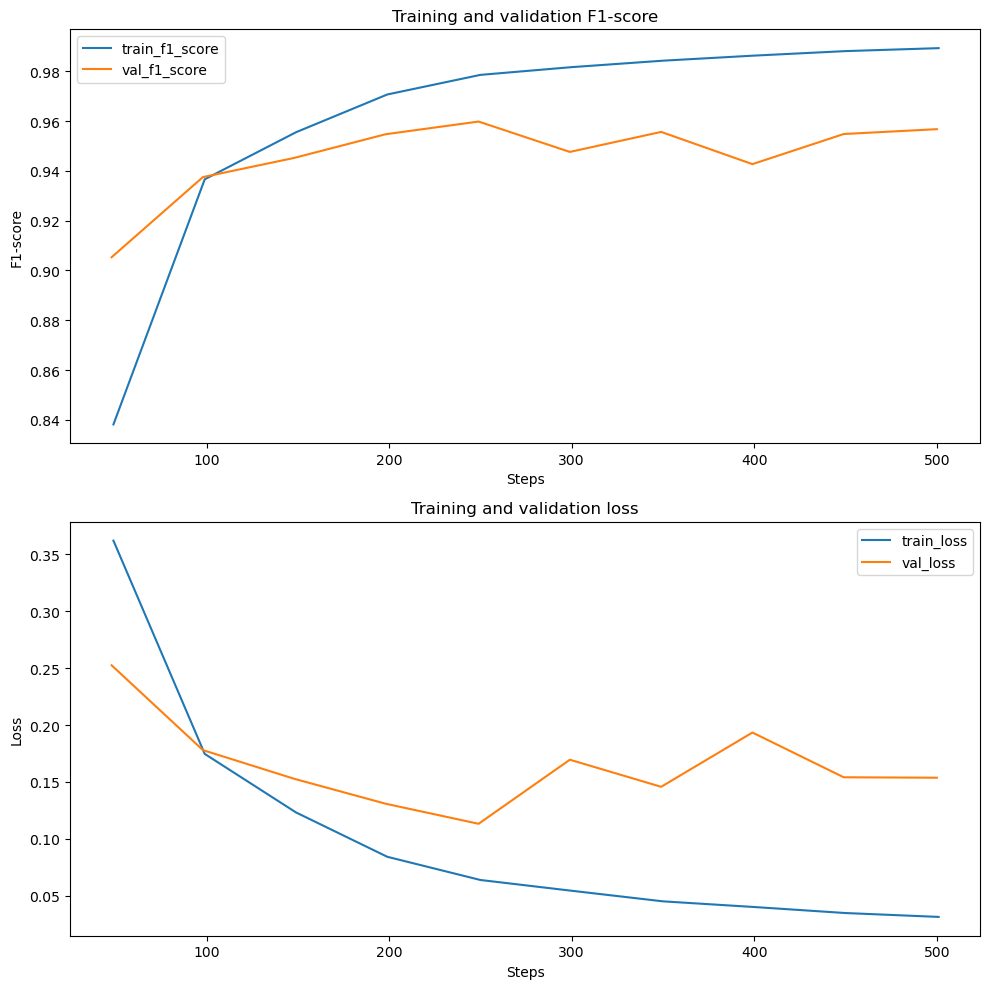

In [ ]:
# plot training curves
plot_training_curves(r'D:\Documents\Master_Data_Science\Thesis\thesis_code\DataScience_Thesis\logs\across_sub_pretext_task\version_14\metrics.csv')

## Pretext model with 0.5 dropout and no weight decay

In [9]:
model = train_pretext_model(
    pretext_task='acrosssub_0.5dropout_0wd_pretext_model',
    max_epochs=50,
    data_train=data_train,
    data_val=data_val,
    batch_size=1000,
    learning_rate=1e-5,
    dropout=0.5,
    weight_decay=0,
    store_weights=(True, True)
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | EEGNet   | EEGNet            | 63.9 K
1 | linear   | Linear            | 101   
2 | train_f1 | MulticlassF1Score | 0     
3 | val_f1   | MulticlassF1Score | 0     
-----------------------------------------------
64.0 K    Trainable params
0         Non-trainable params
64.0 K    Total params
0.256     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Best model checkpoint path: logs\across_sub_pretext_task\version_9\checkpoints\epoch=47-train_loss=0.45-train_f1=0.80-val_loss=0.51-val_f1=0.73.ckpt


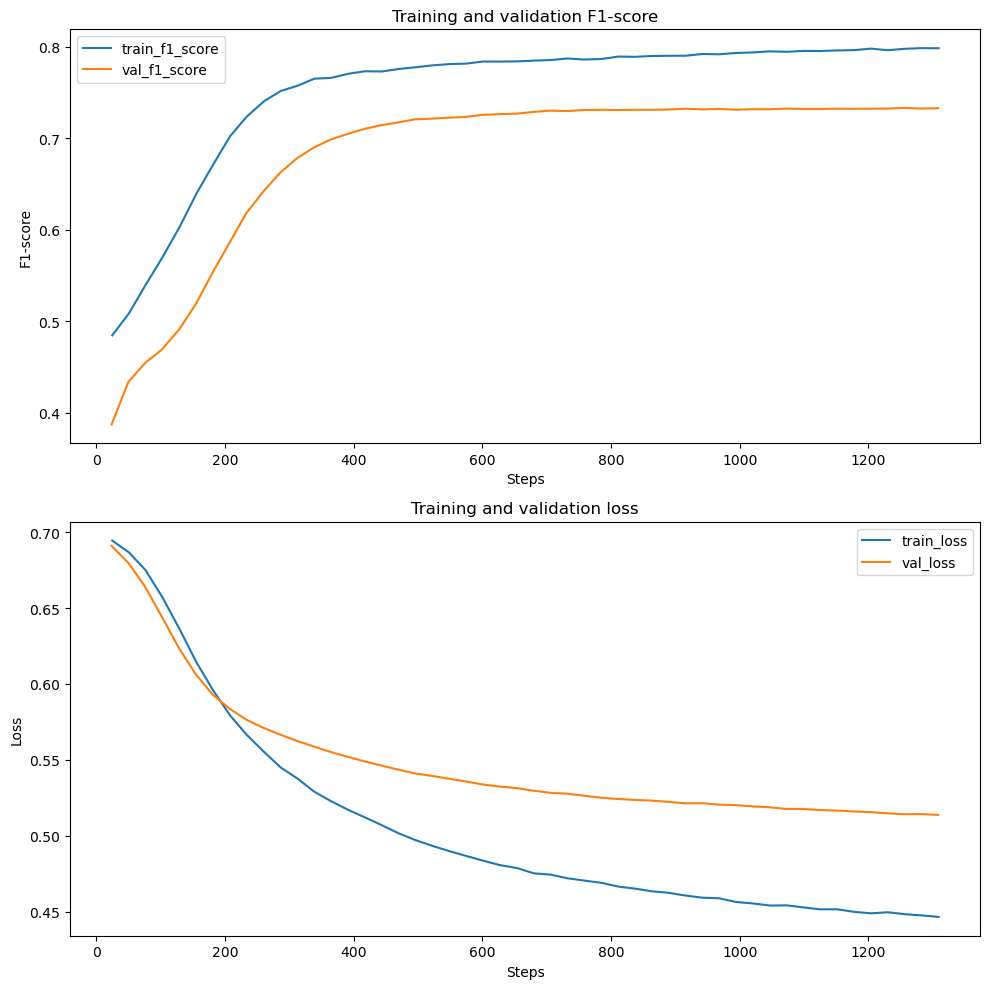

In [10]:
# plot training curves
plot_training_curves(r'D:\Documents\Master_Data_Science\Thesis\thesis_code\DataScience_Thesis\logs\across_sub_pretext_task\version_9\metrics.csv')

## Pretext model with 0.01 weight decay and 0.25 dropout

In [12]:
model = train_pretext_model(
    pretext_task='acrosssub_0.25dropout_0.01wd_pretext_model',
    max_epochs=50,
    data_train=data_train,
    data_val=data_val,
    batch_size=1000,
    learning_rate=1e-5,
    dropout=0.25,
    weight_decay=0.01,
    store_weights=(True, True)
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | EEGNet   | EEGNet            | 63.9 K
1 | linear   | Linear            | 101   
2 | train_f1 | MulticlassF1Score | 0     
3 | val_f1   | MulticlassF1Score | 0     
-----------------------------------------------
64.0 K    Trainable params
0         Non-trainable params
64.0 K    Total params
0.256     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Best model checkpoint path: logs\across_sub_pretext_task\version_10\checkpoints\epoch=48-train_loss=0.45-train_f1=0.80-val_loss=0.45-val_f1=0.80.ckpt


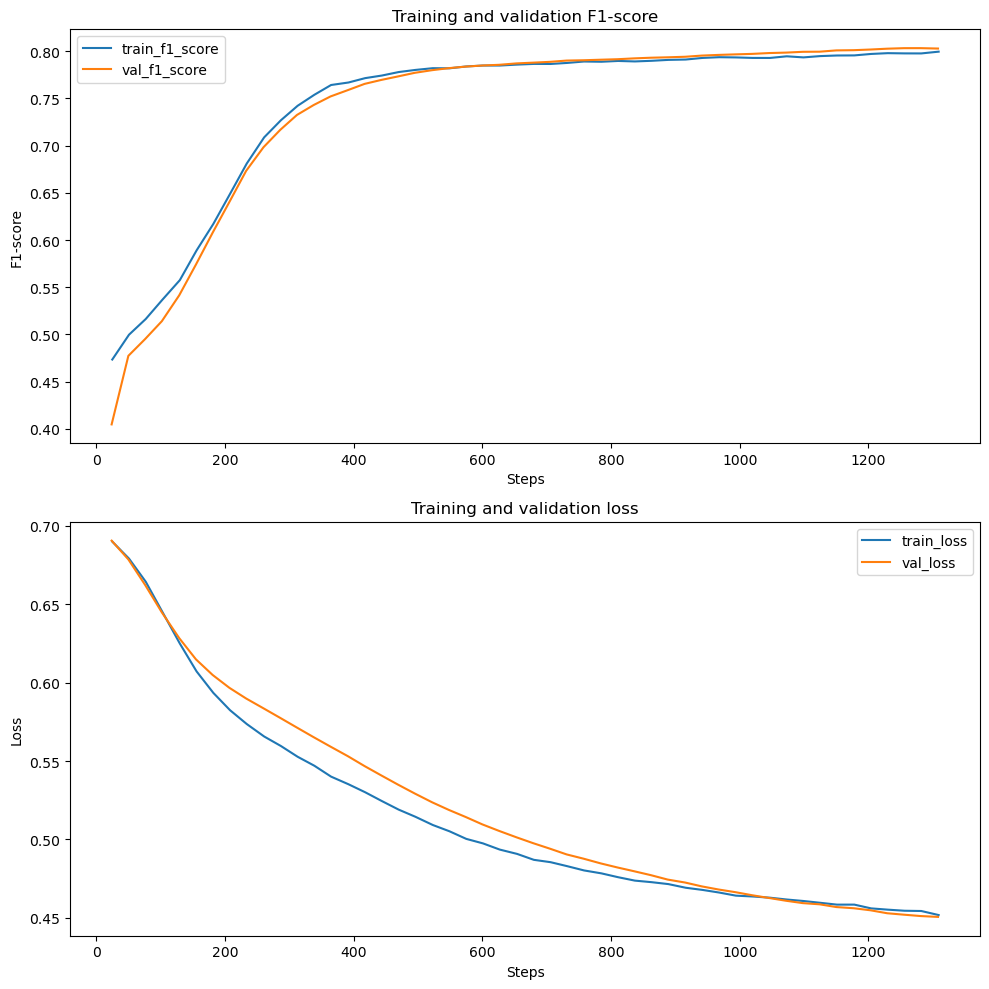

In [13]:
# plot training curves
plot_training_curves(r'D:\Documents\Master_Data_Science\Thesis\thesis_code\DataScience_Thesis\logs\across_sub_pretext_task\version_10\metrics.csv')

## Pretext model 150 features

In [7]:
model = train_pretext_model(
    pretext_task='acrosssub_150feat_pretext_model',
    max_epochs=30,
    data_train=data_train,
    data_val=data_val,
    batch_size=1000,
    learning_rate=0.001,
    dropout=0.25,
    weight_decay=0,
    num_extracted_features=150,
    store_weights=(True, True)
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | EEGNet   | EEGNet            | 95.1 K
1 | linear   | Linear            | 151   
2 | train_f1 | MulticlassF1Score | 0     
3 | val_f1   | MulticlassF1Score | 0     
-----------------------------------------------
95.3 K    Trainable params
0         Non-trainable params
95.3 K    Total params
0.381     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


Before loading checkpoint:
EEGNet.lin.weight shape: torch.Size([150, 624])
linear.weight shape: torch.Size([1, 150])
Best model checkpoint path: logs\across_sub_pretext_task\version_3\checkpoints\epoch=15-train_loss=0.08-train_f1=0.97-val_loss=0.24-val_f1=0.93.ckpt
After loading checkpoint:
EEGNet.lin.weight shape: torch.Size([150, 624])
linear.weight shape: torch.Size([1, 150])


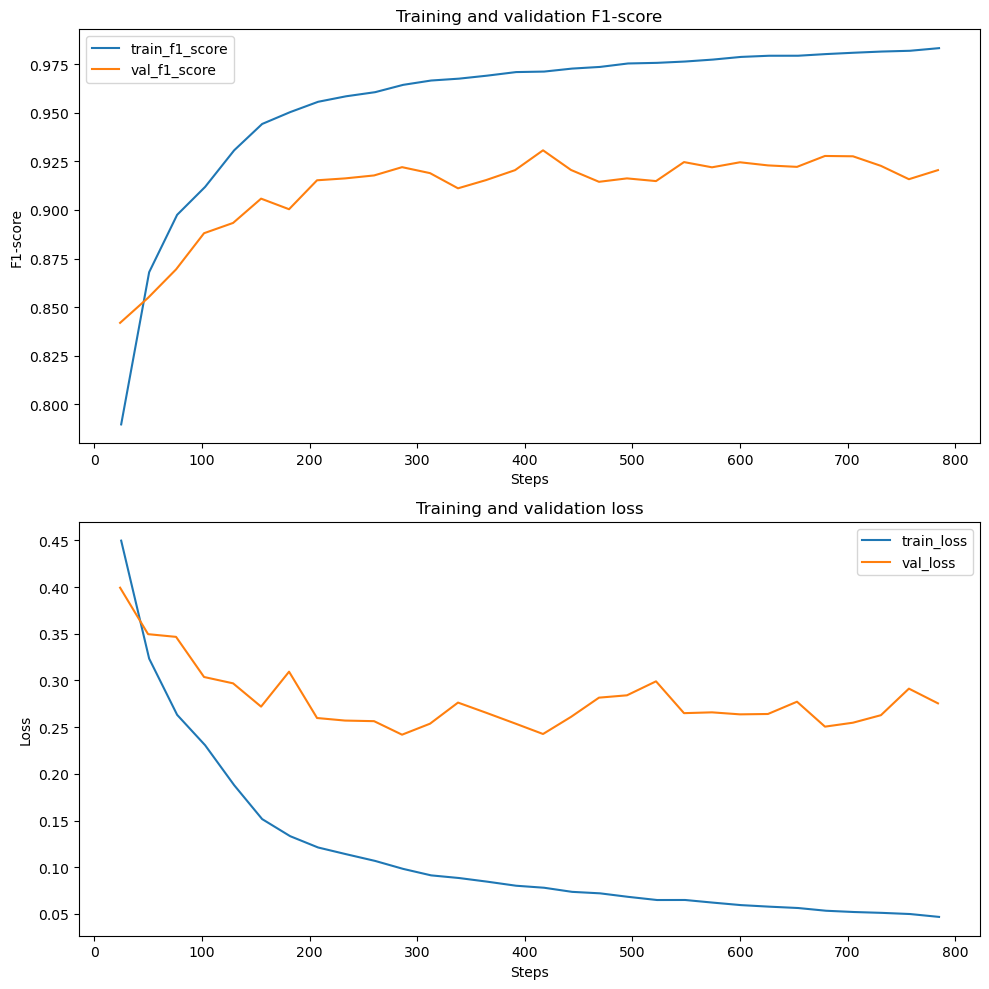

In [8]:
# plot training curves
plot_training_curves(r'D:\Documents\Master_Data_Science\Thesis\thesis_code\DataScience_Thesis\logs\across_sub_pretext_task\version_3\metrics.csv')

## Pretext model with ShallowNet 150 features

In [7]:
# train pretext model with default parameters
model = train_pretext_model(
    pretext_task='acrosssub_shallownet_150feat_pretext_model',
    max_epochs=10,
    data_train=data_train,
    data_val=data_val,
    batch_size=500,
    learning_rate=0.001,
    dropout=0.25,
    weight_decay=0,
    num_extracted_features=150,
    store_weights=(True, True),
    pretext_model='ShallowNet'
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params
-------------------------------------------------
0 | ShallowNet | ShallowNet        | 504 K 
1 | linear     | Linear            | 151   
2 | train_f1   | MulticlassF1Score | 0     
3 | val_f1     | MulticlassF1Score | 0     
-------------------------------------------------
505 K     Trainable params
0         Non-trainable params
505 K     Total params
2.020     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Best model checkpoint path: logs\across_sub_pretext_task\version_13\checkpoints\epoch=7-train_loss=0.04-train_f1=0.99-val_loss=0.12-val_f1=0.96.ckpt


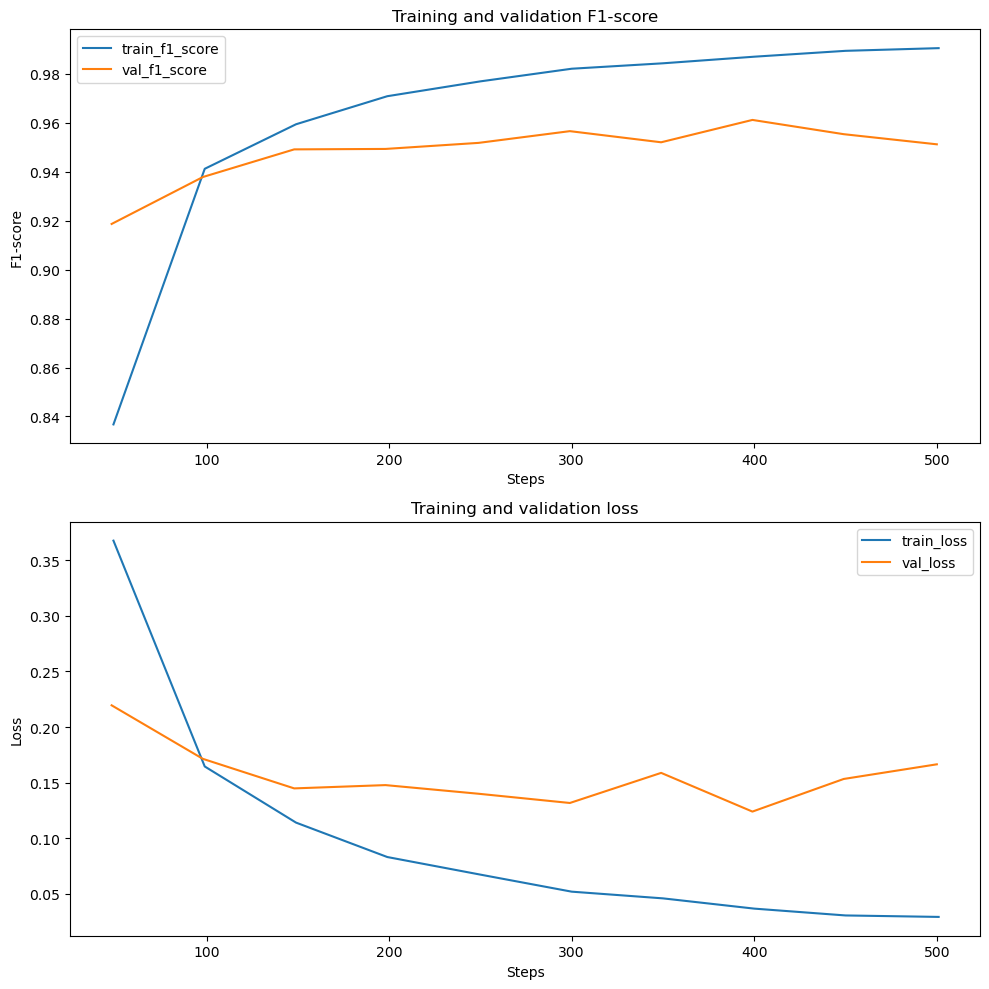

In [8]:
# plot training curves
plot_training_curves(r'D:\Documents\Master_Data_Science\Thesis\thesis_code\DataScience_Thesis\logs\across_sub_pretext_task\version_13\metrics.csv')

## Training pretext model 50 features

In [8]:
# train pretext model with default parameters
model = train_pretext_model(
    pretext_task='acrosssub_50feat_pretext_model',
    max_epochs=30,
    data_train=data_train,
    data_val=data_val,
    batch_size=1000,
    learning_rate=0.001,
    dropout=0.25,
    weight_decay=0,
    num_extracted_features=50,
    store_weights=(True, True)
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | EEGNet   | EEGNet            | 32.7 K
1 | linear   | Linear            | 51    
2 | train_f1 | MulticlassF1Score | 0     
3 | val_f1   | MulticlassF1Score | 0     
-----------------------------------------------
32.8 K    Trainable params
0         Non-trainable params
32.8 K    Total params
0.131     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


Best model checkpoint path: logs\across_sub_pretext_task\version_8\checkpoints\epoch=22-train_loss=0.08-train_f1=0.97-val_loss=0.20-val_f1=0.94.ckpt


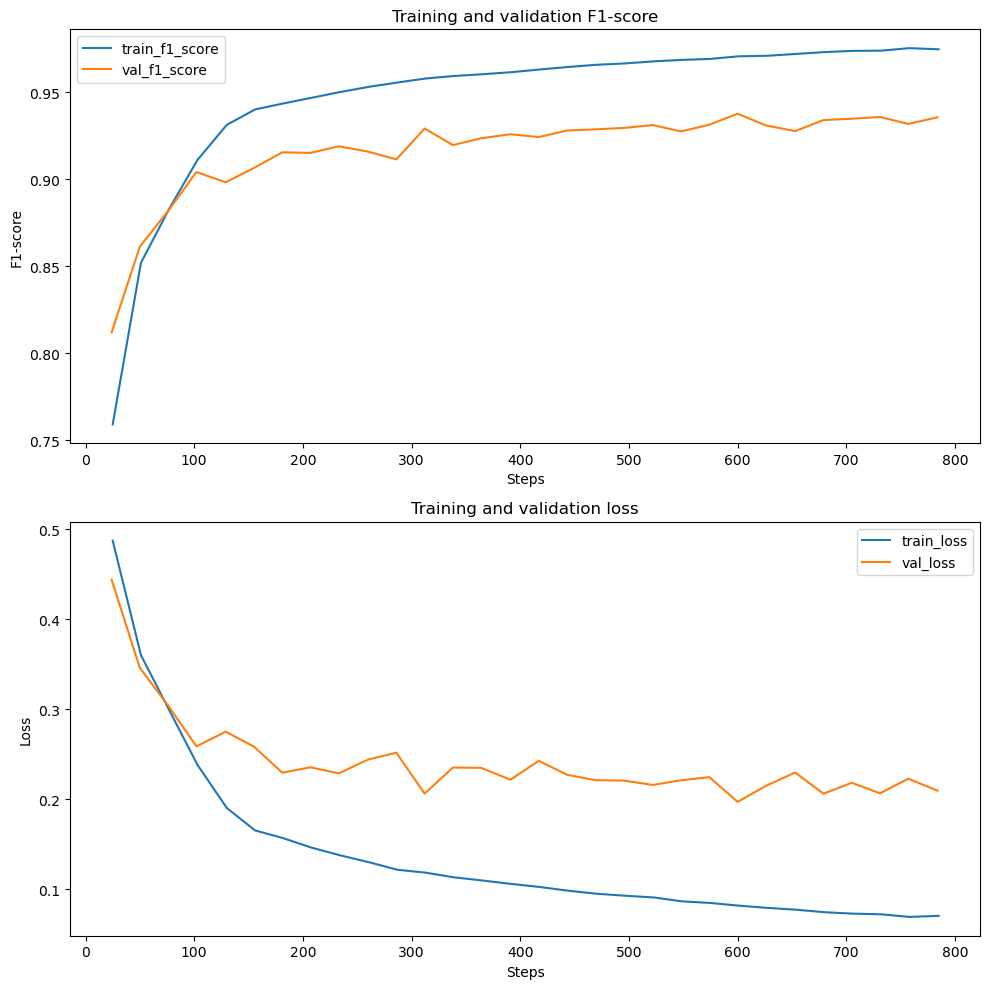

In [9]:
# plot training curves
plot_training_curves(r'D:\Documents\Master_Data_Science\Thesis\thesis_code\DataScience_Thesis\logs\across_sub_pretext_task\version_8\metrics.csv')